<a href="https://colab.research.google.com/github/anikak24/INST414-Module-Assignment-2/blob/main/INST414_MediumPost2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install pandas networkx matplotlib

In [6]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import kagglehub

In [7]:
path = kagglehub.dataset_download("pranavbadami/nj-transit-amtrak-nec-performance")
print("Path to dataset files:", path)

100%|██████████| 103M/103M [00:00<00:00, 115MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pranavbadami/nj-transit-amtrak-nec-performance/versions/2


In [8]:
import os
os.listdir(path)

['2020_05.csv',
 '2018_11.csv',
 'invalid_trains.csv',
 '2019_10.csv',
 '2018_10.csv',
 '2018_12.csv',
 '2018_04.csv',
 '2020_01.csv',
 '2020_04.csv',
 '2018_03.csv',
 '2018_08.csv',
 '2018_06.csv',
 '2019_11.csv',
 '2018_09.csv',
 'invalid_trains_05-01-19_05-18-20.csv',
 '2018_07.csv',
 '2019_04.csv',
 '2019_07.csv',
 '2019_12.csv',
 '2019_01.csv',
 '2020_03.csv',
 '2019_05.csv',
 '2019_09.csv',
 '2020_02.csv',
 '2019_06.csv',
 '2018_05.csv',
 '2019_03.csv',
 '2019_08.csv',
 '2019_02.csv']

In [12]:
df = pd.read_csv(f"{path}/2020_03.csv")
df.head()

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type
0,2020-03-01,1837,1.0,Hoboken,63,Hoboken,63,2020-03-01 22:15:00,2020-03-01 22:16:06,1.100000,departed,Main Line,NJ Transit
1,2020-03-01,1837,2.0,Hoboken,63,Secaucus Lower Lvl,38174,2020-03-01 22:25:00,2020-03-01 22:26:04,1.066667,departed,Main Line,NJ Transit
2,2020-03-01,1837,3.0,Secaucus Lower Lvl,38174,Kingsland,66,2020-03-01 22:31:00,2020-03-01 22:33:37,2.616667,departed,Main Line,NJ Transit
3,2020-03-01,1837,4.0,Kingsland,66,Lyndhurst,75,2020-03-01 22:34:00,2020-03-01 22:35:04,1.066667,departed,Main Line,NJ Transit
4,2020-03-01,1837,5.0,Lyndhurst,75,Delawanna,33,2020-03-01 22:36:00,2020-03-01 22:38:01,2.016667,departed,Main Line,NJ Transit


In [13]:
df_edges = df[['from', 'to']].dropna()
df_edges.head()

,from,to
0,Hoboken,Hoboken
1,Hoboken,Secaucus Lower Lvl
2,Secaucus Lower Lvl,Kingsland
3,Kingsland,Lyndhurst
4,Lyndhurst,Delawanna


In [44]:
df_edges = df[["from_id", "to_id", "from", "to"]].dropna()
df_edges = df_edges[df_edges["from_id"] != df_edges["to_id"]]

In [56]:
dup_check = df_edges.groupby('from_id')['from'].nunique().reset_index()
if (dup_check['from'] > 1).any():
    print("Some station IDs have multiple names!")

df_edges_clean = df_edges.drop_duplicates(subset='pair').copy()

df_edges_clean[['from', 'to']] = pd.DataFrame(df_edges_clean['pair'].tolist(), index=df_edges_clean.index)
df_edges_clean = df_edges_clean[['from', 'to']]

missing_count = df_edges[
    df_edges['from'].isna() | df_edges['to'].isna() |
    (df_edges['from'].str.strip() == '') | (df_edges['to'].str.strip() == '')
].shape[0]

print(f"Number of rows with missing station names: {missing_count}")
print(f"Unique stations: {len(pd.unique(df_edges_clean[['from', 'to']].values.ravel()))}")
print(f"Unique connections: {len(df_edges_clean)}")

Number of rows with missing station names: 0
Unique stations: 164
Unique connections: 286


In [26]:
g = nx.Graph()
for _, row in df_edges.iterrows():
    g.add_edge(row['from'], row['to'])

In [20]:
degree_centrality = nx.degree_centrality(g)
betweenness_centrality = nx.betweenness_centrality(g, normalized=True)
pagerank = nx.pagerank(g)

In [51]:
centrality_df = pd.DataFrame({
    'station_name': list(degree_centrality.keys()),
    'degree': list(degree_centrality.values()),
    'betweenness': [betweenness_centrality[n] for n in g.nodes()],
    'pagerank': [pagerank[n] for n in g.nodes()]
}).sort_values(by="betweenness", ascending=False).reset_index(drop=True)

top_10 = centrality_df.sort_values('betweenness', ascending=False).head(10)
top_10

print(f"Number of stations (nodes): {g.number_of_nodes()}")
print(f"Number of connections (edges): {g.number_of_edges()}")

def top_n(d, n=10):
    return sorted(d.items(), key=lambda x: x[1], reverse=True)[:n]

styled = (
    top_10.style
    .background_gradient(subset=["degree", "betweenness", "pagerank"])
    .format({
        "Degree Centrality": "{:.4f}",
        "Betweenness Centrality": "{:.4f}",
        "PageRank": "{:.4f}"
    })
    .set_caption("Top 10 Most Central Stations in NJ Transit Rail Network")
)
display(styled)

Number of stations (nodes): 164
Number of connections (edges): 286


,station_name,degree,betweenness,pagerank
0,Newark Penn Station,0.122699,0.540793,0.020909
1,Secaucus Lower Lvl,0.079755,0.465749,0.019040
2,Hoboken,0.036810,0.442359,0.006903
3,Newark Broad Street,0.085890,0.265336,0.015410
4,New York Penn Station,0.055215,0.218482,0.009644
5,South Orange,0.067485,0.213643,0.012317
6,South Amboy,0.024540,0.172814,0.006083
7,Aberdeen-Matawan,0.012270,0.157994,0.004397
8,Chatham,0.024540,0.149432,0.005644
9,Hazlet,0.012270,0.147694,0.005151


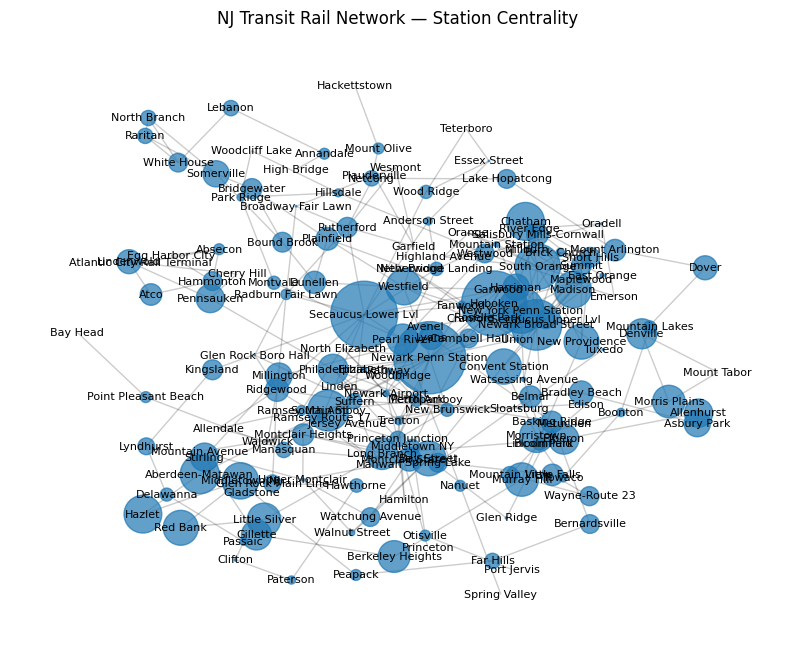

In [34]:
plt.figure(figsize=(10,8))
pos = nx.spring_layout(g, k=0.15, iterations=20)

node_size = [5000 * betweenness_centrality[v] for v in g]
nx.draw_networkx_nodes(g, pos, node_size=node_size, alpha=0.7)
nx.draw_networkx_edges(g, pos, alpha=0.2)
nx.draw_networkx_labels(g, pos, font_size=8)
plt.title("NJ Transit Rail Network — Station Centrality")
plt.axis('off')
plt.show()